# **Import**

In [1]:
# !pip install geopy
# !pip install pyarrow
# !pip install fastparquet

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

import gc
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random

from yellowbrick.target import FeatureCorrelation
from datetime import datetime, timedelta
import time 

# 직접 제작한 패키지
import Jeju_ as jj

import warnings
warnings.filterwarnings(action='ignore')

# **DATA 불러오기**

## **_csv to parquet**
- 메모리에 효율적인 데이터 유형을 사용하여 용량을 크게 줄이고 빠른 작업이 가능합니다.

In [4]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [6]:
# csv_to_parquet('../DAT/train.csv', '../DAT/train')
# csv_to_parquet('../DAT/test.csv', '../DAT/test')

## **_데이터 불러오기**

### **__Train and test**

In [7]:
train = pd.read_parquet('../DAT/train.parquet')
test = pd.read_parquet('../DAT/test.parquet')

In [8]:
print(train.shape, test.shape)
train.head(3)

(4701217, 23) (291241, 22)


,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0


## **_외부 데이터**

### **___날씨 데이터**

In [9]:
weather21 = pd.read_csv("../DAT/2021 제주날씨.csv", encoding = "cp949")
weather21 = weather21.drop(columns = ["지점"]).fillna(0)
weather21.columns = ['지점명', '일시', '평균기온', '일강수량', '평균풍속', '평균상대습도', '합계일사량', '일최심적설', '평균 지면온도']

weather22 = pd.read_csv("../DAT/2022 제주날씨.csv", encoding = "cp949")
weather22 = weather22.drop(columns = ["지점"]).fillna(0)
weather22.columns = ['지점명', '일시', '평균기온', '일강수량', '평균풍속', '평균상대습도', '합계일사량', '일최심적설', '평균 지면온도']

In [13]:
weather_jj = pd.concat([weather21[weather21["지점명"] == "제주"], weather22[weather22["지점명"] == "제주"]], axis = 0).reset_index(drop = True)
weather_sq = pd.concat([weather21[weather21["지점명"] == "서귀포"], weather22[weather22["지점명"] == "서귀포"]], axis = 0).reset_index(drop = True)

### 제주와 서귀포 날씨 평균
weather = pd.concat([weather_jj["일시"], (weather_jj.iloc[:, 2:] + weather_sq.iloc[:, 2:])/2], axis = 1)
# weather.head()

### **___Covid19**

In [15]:
### 제주도 코로나 확진자 수
covid19 = pd.read_csv("../DAT/covid_jj.csv", encoding = "cp949").iloc[:, :2]
covid19.columns = ["일자", "covid"]
covid19["covid"] = covid19["covid"].astype(int)
# covid19.head(3)

### **__1차 전처리 Train/Test data**

In [11]:
# train2 = pd.read_parquet('../DAT/pro_train.parquet')
# test2 = pd.read_parquet('../DAT/pro_test.parquet')

# **데이터 전처리**

## **_JJ 함수 적용**

In [17]:
train2 = jj.dist_(train)              # dist_: 출발지점의 위도,경도와 도착지점의 위도, 경도간의 거리
train2 = jj.road_(train2)                 # road_: 도로 종류에 따른 범주형 변수 생성
train2 = jj.weather_(train2, weather)     # weather_: 하루 전 날씨를 매칭
train2 = jj.covid_(train2, covid19)       # covid_: 하루 전 코로나 확진자 수를 매칭
train2 = jj.cat_onehot(train2)            # cat_onehot: 원 변수 중 범주형 변수들에 OneHotEncoding 적용
print("=="*50)
test2 = jj.dist_(test)
test2 = jj.road_(test2)
test2 = jj.weather_(test2, weather)
test2 = jj.covid_(test2, covid19)
test2 = jj.cat_onehot(test2)

## **_변수 제거 및 이름 변경**

In [13]:
drop_var = ["id", "height_restricted", "vehicle_restricted", "connect_code", "multi_linked", "start_node_name", "end_node_name", "road_name", "일시", "일자"]
train3 = train2.drop(columns = drop_var)
test3 = test2.drop(columns = drop_var)
train3.rename(columns = {'평균기온': "temp", '일강수량' : "rain", '평균풍속' : "wind", '평균상대습도' : "humidity", 
                         '합계일사량' : "sunny", '일최심적설' : "snow", '평균 지면온도' : "land_temp"}, inplace = True)
test3.rename(columns = {'평균기온': "temp", '일강수량' : "rain", '평균풍속' : "wind", '평균상대습도' : "humidity", 
                        '합계일사량' : "sunny", '일최심적설' : "snow", '평균 지면온도' : "land_temp"}, inplace = True)

# display(train3.head(3))
# display(test3.head(3))

## **_추가 파생 변수 생성**

In [14]:
### 최대 속도제한 / 차선 수
train3["mpl_lc"] = train3["maximum_speed_limit"] / train3["lane_count"]
test3["mpl_lc"] = test3["maximum_speed_limit"] / test3["lane_count"]

### 거리 / 차선 수
train3["dist_lc"] = train3["dist"] / train3["lane_count"]
test3["dist_lc"] = test3["dist"] / test3["lane_count"]

In [15]:
### 월 변수
train3["month"] = train3["base_date"].dt.month
train3.drop(columns = ["base_date"], inplace = True)
train3 = jj.cat_onehot(train3, var = ["month"])


test3["month"] = test3["base_date"].dt.month
test3.drop(columns = ["base_date"], inplace = True)
test3 = jj.cat_onehot(test3, var = ["month"])

## **_전처리 한 데이터 저장**

In [16]:
print(train3.shape, test3.shape)
train3.to_csv("../DAT/pro_train2.csv", index = False)
test3.to_csv("../DAT/pro_test2.csv", index = False)
csv_to_parquet('../DAT/pro_train2.csv', '../DAT/pro_train2')
csv_to_parquet('../DAT/pro_test2.csv', '../DAT/pro_test2')

In [18]:
# train3 = pd.read_parquet('../DAT/pro_train2.parquet')
# test3 = pd.read_parquet('../DAT/pro_test2.parquet')

# **변수 관계 파악**

## **_변수 유형별 분류**

In [19]:
num_var = ['base_hour', 'lane_count', 'maximum_speed_limit', 'start_latitude', 'start_longitude', 'end_latitude', 'end_longitude', 
           "dist", 'dist_jeju_start', 'dist_jeju_end', 'dist_seoqui_start', 'dist_seoqui_end', "dist_airport_start", "dist_airport_end",
           'temp', 'rain', 'wind', 'humidity', 'sunny', 'snow', 'land_temp', "covid",
           "mpl_lc", "dist_lc"]
weather_var = ['temp', 'rain', 'wind', 'humidity', 'sunny', 'snow', 'land_temp', "covid"]
cat_var = sorted( list(set(train3.columns) - set(num_var) - set(["target"])) )
print(len(num_var), len(cat_var))
print(cat_var)

24 21
['day_of_week_1', 'day_of_week_2', 'end_turn_restricted_없음', 'end_turn_restricted_있음', 'road_name__1', 'road_name__2', 'road_name__3', 'road_name__4', 'road_name__5', 'road_name__6', 'road_rating_103', 'road_rating_106', 'road_rating_107', 'road_type_0', 'road_type_3', 'start_turn_restricted_없음', 'start_turn_restricted_있음', 'weight_restricted_0.0', 'weight_restricted_32400.0', 'weight_restricted_43200.0', 'weight_restricted_50000.0']


## **_연속형 변수: 상관관계**

,base_hour,lane_count,maximum_speed_limit,start_latitude,start_longitude,end_latitude,end_longitude,dist,dist_jeju_start,dist_jeju_end,...,rain,wind,humidity,sunny,snow,land_temp,covid,mpl_lc,dist_lc,target
target,-0.159407,-0.144256,0.425715,0.03628,-0.001168,0.036139,-0.001,0.181093,0.102714,0.103665,...,0.002595,0.004884,-0.024696,-0.029595,-0.008309,-0.039296,-0.000157,0.315723,0.147172,1.0


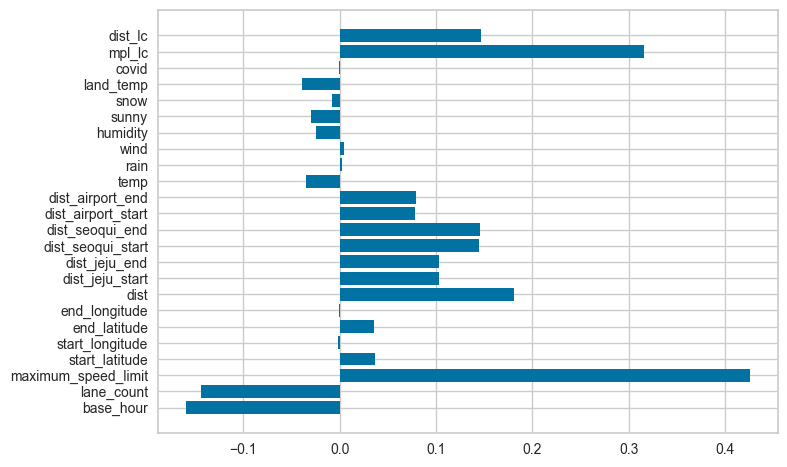

In [20]:
display(train3[num_var + ["target"]].corr().iloc[[-1],:])
X, y = train3[num_var], train3["target"]
features = np.array(num_var)
visualizer = FeatureCorrelation(labels = num_var)
visualizer.fit(X, y);

## **_범주형 변수에 따른 Target 범위**

In [22]:
for i in range(len(cat_var)) :
    target = train3[train3[cat_var[i]] == 1]["target"]
    print("%s - 평균 : %.5f| 최소 : %.5f| 최대 : %.5f" % (cat_var[i], np.round(target.mean(), 4), np.round(target.min(), 4), np.round(target.max(), 4)))

day_of_week_1 - 평균 : 42.83910| 최소 : 1.00000| 최대 : 112.00000
day_of_week_2 - 평균 : 42.75000| 최소 : 1.00000| 최대 : 113.00000
end_turn_restricted_없음 - 평균 : 43.64560| 최소 : 1.00000| 최대 : 113.00000
end_turn_restricted_있음 - 평균 : 34.91620| 최소 : 1.00000| 최대 : 98.00000
road_name__1 - 평균 : 46.47910| 최소 : 1.00000| 최대 : 113.00000
road_name__2 - 평균 : 33.06290| 최소 : 1.00000| 최대 : 98.00000
road_name__3 - 평균 : 38.45850| 최소 : 3.00000| 최대 : 75.00000
road_name__4 - 평균 : 47.37680| 최소 : 1.00000| 최대 : 99.00000
road_name__5 - 평균 : 24.98080| 최소 : 4.00000| 최대 : 54.00000
road_name__6 - 평균 : 44.77460| 최소 : 1.00000| 최대 : 94.00000
road_rating_103 - 평균 : 46.38850| 최소 : 1.00000| 최대 : 113.00000
road_rating_106 - 평균 : 48.02150| 최소 : 1.00000| 최대 : 99.00000
road_rating_107 - 평균 : 34.70140| 최소 : 1.00000| 최대 : 94.00000
road_type_0 - 평균 : 41.16090| 최소 : 1.00000| 최대 : 113.00000
road_type_3 - 평균 : 49.09710| 최소 : 3.00000| 최대 : 103.00000
start_turn_restricted_없음 - 평균 : 43.61020| 최소 : 1.00000| 최대 : 113.00000
start_turn_restricted_있

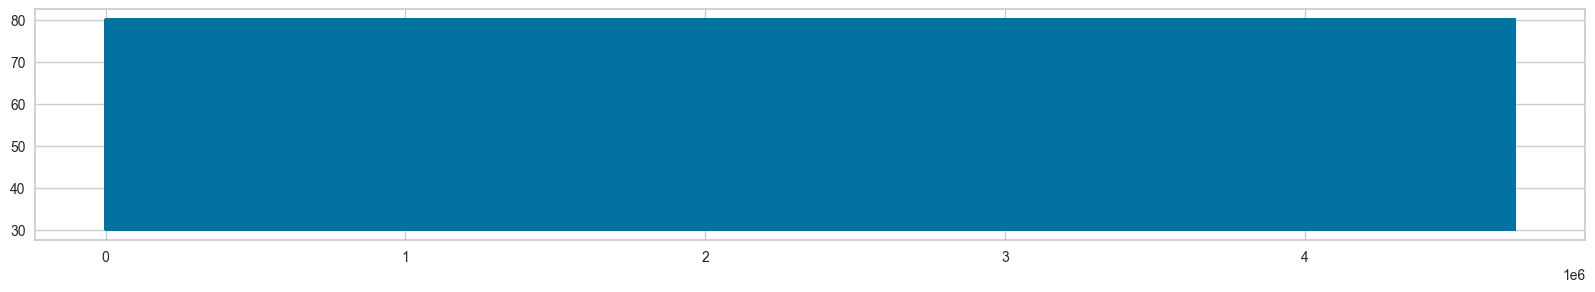

In [23]:
plt.figure(figsize = (20,3))
plt.plot(train3["maximum_speed_limit"]);

## **_차선 수에 따른 Target 평균**

In [24]:
for i in range(1, 4, 1) : 
    target_mean = train3[train3["lane_count"] == i].target.mean()
    print("lane count(%d) : %.4f" % (i, target_mean))

lane count(1) : 43.5706
lane count(2) : 44.9157
lane count(3) : 34.9178


In [22]:
# train3 = train3.drop(index = train3[train3["target"] >= 85].index).reset_index(drop = True)

In [24]:
# for i in range(len(cat_var)) : 
#     target_mean = train3[train3[cat_var[i]] == 1].target.mean()
#     print("%s (%d) : %.4f" % (cat_var[i], train3[train3[cat_var[i]] == 1].shape[0], target_mean))